# Comprehensive Model Testing & Comparison

---

This notebook loads and tests all trained models from the `models/` folder.

**Available Models:**
1. Vanilla CNN Baseline (Classification - Dual Head)
2. Vanilla CNN Optimized (Classification - Dual Head)
3. ConvNeXt V2 Baseline (Classification - Dual Head)
4. Swin Transformer V2 Baseline (Classification - Dual Head)
5. Vanilla CNN Depth Baseline (Regression)
6. Vainilla Cnn Depth optimized
7. ConvNeXt V2 Depth with Frozen Backbone (Regression)
8. ConvNeXt V2 Depth Unfrozen / Full Fine-tuning (Regression)
9. Swin Transformer V2 Depth Phase 1 (Regression)
0. Swin Transformer V2 Depth Phase 2 (Regression)

**Hardware:** Apple M4 + 24GB Unified Memory (MPS)

---

## 1. Setup & Imports

In [1]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

# Transfer learning
import timm

# Data & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torchvision.transforms as T

# Project modules
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

from src.data.pose_dataset import ClassificationDataset
from src.data.depth_dataset import RegressDataset
from src.utils import create_stratified_splits
from src.utils.regression_utils import (
    collect_predictions_regression,
    compute_regression_metrics
)

# Set device
# Determine the device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully")

Using device: mps
All libraries imported successfully


## 2. Model Architecture Definitions

**Note:** Classification models use dual-head architecture (separate heads for pitch and roll)

In [2]:

# CLASSIFICATION MODELS (DUAL-HEAD)

class VanillaCNNDualHead(nn.Module):
    """
    Vanilla CNN with dual-head for pitch and roll classification
    
    **IMPORTANT**: This architecture matches the actual trained models!
    Uses ModuleList for features and Linear (not Sequential) for heads.
    """
    def __init__(
        self,
        num_pitch_classes=18,
        num_roll_classes=7,
        channels=[32, 64, 128, 256, 512],
        fc_dim=256,
        dropout_rate=0.3,
        use_bn=True
    ):
        super(VanillaCNNDualHead, self).__init__()
        
        self.use_bn = use_bn
        
        # Feature extraction backbone (5 conv blocks with ModuleList)
        self.features = nn.ModuleList()
        
        in_channels = 3
        for out_channels in channels:
            block = []
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_bn:
                block.append(nn.BatchNorm2d(out_channels))
            block.append(nn.ReLU(inplace=True))
            block.append(nn.MaxPool2d(2, 2))
            
            self.features.append(nn.Sequential(*block))
            in_channels = out_channels
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Shared fully connected layer
        self.fc_shared = nn.Sequential(
            nn.Linear(channels[-1], fc_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
        # Pitch and roll heads (just Linear, no Sequential wrapper)
        self.pitch_head = nn.Linear(fc_dim, num_pitch_classes)
        self.roll_head = nn.Linear(fc_dim, num_roll_classes)
    
    def forward(self, x):
        # Feature extraction
        for layer in self.features:
            x = layer(x)
        
        # Global pooling
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        
        # Shared FC layer
        features = self.fc_shared(x)
        
        # Dual heads
        pitch_out = self.pitch_head(features)
        roll_out = self.roll_head(features)
        
        return pitch_out, roll_out


class ConvNeXtV2DualHead(nn.Module):
    """ConvNeXt V2 with dual-head for pitch and roll classification"""
    def __init__(self, num_pitch_classes=18, num_roll_classes=7, pretrained=True, dropout_rate=0.3):
        super(ConvNeXtV2DualHead, self).__init__()
        
        self.backbone = timm.create_model(
            'convnextv2_tiny.fcmae_ft_in22k_in1k',
            pretrained=pretrained,
            num_classes=0
        )
        
        self.feature_dim = self.backbone.num_features
        
        # Pitch head
        self.pitch_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_pitch_classes)
        )
        
        # Roll head
        self.roll_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_roll_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        pitch_out = self.pitch_head(features)
        roll_out = self.roll_head(features)
        return pitch_out, roll_out


class SwinV2DualHead(nn.Module):
    """Swin Transformer V2 with dual-head for pitch and roll classification"""
    def __init__(self, num_pitch_classes=18, num_roll_classes=7, pretrained=True, dropout_rate=0.3, img_size=256):
        super(SwinV2DualHead, self).__init__()
        
        # FIXED: Use window16 variant (matches trained model!)
        self.backbone = timm.create_model(
            'swinv2_tiny_window16_256.ms_in1k',  # ← FIXED: window16 (was window8)
            pretrained=pretrained,
            num_classes=0,
            img_size=img_size
        )
        
        self.feature_dim = self.backbone.num_features
        
        # Pitch head
        self.pitch_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_pitch_classes)
        )
        
        # Roll head
        self.roll_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_roll_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        pitch_out = self.pitch_head(features)
        roll_out = self.roll_head(features)
        return pitch_out, roll_out



# REGRESSION MODELS


class VanillaCNNRegression(nn.Module):
    """
    Vanilla CNN for depth regression
    
    **IMPORTANT**: This uses the SAME ModuleList architecture as classification!
    """
    def __init__(
        self,
        channels=[32, 64, 128, 256, 512],
        fc_dim=256,
        dropout_rate=0.5,
        use_bn=True
    ):
        super(VanillaCNNRegression, self).__init__()
        
        self.use_bn = use_bn
        
        # Feature extraction backbone (5 conv blocks with ModuleList - SAME as classification)
        self.features = nn.ModuleList()
        
        in_channels = 3
        for out_channels in channels:
            block = []
            block.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_bn:
                block.append(nn.BatchNorm2d(out_channels))
            block.append(nn.ReLU(inplace=True))
            block.append(nn.MaxPool2d(2, 2))
            
            self.features.append(nn.Sequential(*block))
            in_channels = out_channels
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Shared fully connected layer
        self.fc_shared = nn.Sequential(
            nn.Linear(channels[-1], fc_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        
        # Regression head (just Linear, no Sequential wrapper)
        self.regression_head = nn.Linear(fc_dim, 1)
    
    def forward(self, x):
        # Feature extraction
        for layer in self.features:
            x = layer(x)
        
        # Global pooling
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        
        # Shared FC layer
        features = self.fc_shared(x)
        
        # Regression output
        output = self.regression_head(features)
        
        return output


class ConvNeXtV2Regression(nn.Module):
    """ConvNeXt V2 for depth regression"""
    def __init__(self, pretrained=True, dropout_rate=0.2):
        super(ConvNeXtV2Regression, self).__init__()
        
        self.backbone = timm.create_model(
            'convnextv2_tiny.fcmae_ft_in22k_in1k',
            pretrained=pretrained,
            num_classes=0
        )
        
        self.feature_dim = self.backbone.num_features
        self.regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 1)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.regression_head(features)


class SwinV2Regression(nn.Module):
    """Swin Transformer V2 for depth regression"""
    def __init__(self, pretrained=True, dropout_rate=0.3, img_size=256):
        super(SwinV2Regression, self).__init__()
        
        self.backbone = timm.create_model(
            'swinv2_tiny_window16_256.ms_in1k',
            pretrained=pretrained,
            num_classes=0,
            img_size=img_size
        )
        
        self.feature_dim = self.backbone.num_features
        self.regression_head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 1)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.regression_head(features)

print("All model architectures defined (matching actual trained models)")

All model architectures defined (matching actual trained models)


## 3. Load Datasets

In [3]:
# Data paths
data_root = project_root / 'data'

# Load classification dataset
classification_dataset = ClassificationDataset(rootpath=str(data_root), augment=False)
print(f"Classification dataset size: {len(classification_dataset)}")
print(f"  Pitch classes: {len(classification_dataset.p_dict)}")
print(f"  Roll classes: {len(classification_dataset.r_dict)}")

# Load regression dataset
regression_dataset = RegressDataset(rootpath=str(data_root), augment=False)
print(f"\nRegression dataset size: {len(regression_dataset)}")

Classification dataset size: 2000
  Pitch classes: 18
  Roll classes: 7

Regression dataset size: 2000


In [4]:
# Create test splits using utility functions

# Classification test split (using create_stratified_splits)
train_idx_cls, val_idx_cls, test_idx_cls = create_stratified_splits(
    dataset=classification_dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=42
)

test_subset_cls = Subset(classification_dataset, test_idx_cls)
test_loader_cls = DataLoader(test_subset_cls, batch_size=32, shuffle=False, num_workers=0)

print(f"Classification test set: {len(test_idx_cls)} samples")

# Regression test split (simple random split)
from sklearn.model_selection import train_test_split
all_indices_reg = list(range(len(regression_dataset)))

train_val_idx_reg, test_idx_reg = train_test_split(
    all_indices_reg,
    test_size=0.2,
    random_state=42
)

test_subset_reg = Subset(regression_dataset, test_idx_reg)
test_loader_reg = DataLoader(test_subset_reg, batch_size=8, shuffle=False, num_workers=0)

print(f"Regression test set: {len(test_idx_reg)} samples")

Classification test set: 400 samples
Regression test set: 400 samples


In [5]:
# Create resizing wrapper for Swin-V2 models (need 256x256)
class ResizingDataLoader:
    """Wrapper that resizes images to specified size"""
    def __init__(self, dataloader, target_size=256):
        self.dataloader = dataloader
        self.resize = T.Resize((target_size, target_size))
    
    def __iter__(self):
        for batch in self.dataloader:
            if len(batch) == 2:
                images, targets = batch
                images = self.resize(images)
                yield images, targets
            else:
                yield batch
    
    def __len__(self):
        return len(self.dataloader)

print("Resizing dataloader defined")

Resizing dataloader defined


## 4. Model Registry & Loading

In [6]:
# Model registry: maps model file names to their specifications
# Using OrderedDict to preserve model order throughout analysis
MODEL_REGISTRY = OrderedDict([
    # Classification models (dual-head)
    ('1_vanilla_cnn_baseline_best.pth', {
        'type': 'classification',
        'architecture': VanillaCNNDualHead,
        'name': 'Vanilla CNN Baseline',
        'params': {
            'num_pitch_classes': 18,
            'num_roll_classes': 7,
            'channels': [32, 64, 128, 256, 512],
            'fc_dim': 256,
            'dropout_rate': 0.3,
            'use_bn': True
        },
        'resize': None
    }),
    ('2_vanilla_cnn_optimized_best.pth', {
        'type': 'classification',
        'architecture': VanillaCNNDualHead,
        'name': 'Vanilla CNN Optimized',
        'params': {
            'num_pitch_classes': 18,
            'num_roll_classes': 7,
            'channels': [48, 32, 128, 128, 64],  # Actual optimized channels!
            'fc_dim': 384,
            'dropout_rate': 0.3,
            'use_bn': True
        },
        'resize': None
    }),
    ('3_convnextv2_pose.pth', {
        'type': 'classification',
        'architecture': ConvNeXtV2DualHead,
        'name': 'ConvNeXt V2 Baseline',
        'params': {'num_pitch_classes': 18, 'num_roll_classes': 7, 'pretrained': False, 'dropout_rate': 0.3},
        'resize': None
    }),
    ('4_swin_v2.pth', {
        'type': 'classification',
        'architecture': SwinV2DualHead,
        'name': 'Swin Transformer V2 Baseline',
        'params': {'num_pitch_classes': 18, 'num_roll_classes': 7, 'pretrained': False, 'dropout_rate': 0.3, 'img_size': 256},
        'resize': 256
    }),
    
    # Regression models
    ('5_vanilla_cnn_depth_baseline.pth', {
        'type': 'regression',
        'architecture': VanillaCNNRegression,
        'name': 'Vanilla CNN Depth Baseline',
        'params': {
            'channels': [32, 64, 128, 256, 512],
            'fc_dim': 256,
            'dropout_rate': 0.5,
            'use_bn': True
        },
        'resize': None
    }),
    ('6_vanilla_cnn_optimized_depth_best.pth', {
        'type': 'regression',
        'architecture': VanillaCNNRegression,
        'name': 'Vanilla CNN Optimized Depth',
        'params': {
            'channels': [48, 32, 128, 128, 64],
            'fc_dim': 384,
            'dropout_rate': 0.3,
            'use_bn': True
        },
        'resize': None
    }),
    ('7_convnext_v2_depth_backboneFR.pth', {
        'type': 'regression',
        'architecture': ConvNeXtV2Regression,
        'name': 'ConvNeXt V2 Depth (Frozen Backbone)',
        'params': {'pretrained': False, 'dropout_rate': 0.2},
        'resize': None
    }),
    ('8_convnext_v2_depth_Unfrozen.pth', {
        'type': 'regression',
        'architecture': ConvNeXtV2Regression,
        'name': 'ConvNeXt V2 Depth (Unfrozen / Full Fine-tuning)',
        'params': {'pretrained': False, 'dropout_rate': 0.2},
        'resize': None
    }),
    ('9_swin_v2_depth_phase1.pth', {
        'type': 'regression',
        'architecture': SwinV2Regression,
        'name': 'Swin V2 Depth Phase 1 (Frozen)',
        'params': {'pretrained': False, 'dropout_rate': 0.3, 'img_size': 256},
        'resize': 256
    }),
    ('10_swin_v2_depth_phase2.pth', {
        'type': 'regression',
        'architecture': SwinV2Regression,
        'name': 'Swin V2 Depth Phase 2 (Fine-tuned)',
        'params': {'pretrained': False, 'dropout_rate': 0.3, 'img_size': 256},
        'resize': 256
    }),
])

print(f"Model registry contains {len(MODEL_REGISTRY)} models (order preserved)")

Model registry contains 10 models (order preserved)


In [7]:
def load_model(model_path, model_spec, device):
    """
    Load a model from checkpoint
    
    Args:
        model_path: Path to model checkpoint
        model_spec: Model specification from registry
        device: Device to load model on
    
    Returns:
        Loaded model
    """
    # Initialize model
    model = model_spec['architecture'](**model_spec['params'])
    
    # Load checkpoint
    # NOTE: weights_only=False is needed for PyTorch 2.6+ to load older checkpoints
    # These are our own trusted checkpoints, so this is safe
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Extract state dict (handle different checkpoint formats)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # Load weights
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    return model

print("Model loading function defined (with PyTorch 2.6 compatibility)")

Model loading function defined (with PyTorch 2.6 compatibility)


## 5. Evaluation Functions

In [8]:
def evaluate_classification_model(model, dataloader, device):
    """
    Evaluate a dual-head classification model
    
    Returns:
        Dictionary with metrics for both pitch and roll
    """
    model.eval()
    pitch_preds = []
    pitch_labels = []
    roll_preds = []
    roll_labels = []
    
    with torch.no_grad():
        for images, labels_dict in dataloader:
            images = images.to(device)
            
            # Forward pass
            pitch_out, roll_out = model(images)
            
            # Get predictions
            _, pitch_pred = torch.max(pitch_out, 1)
            _, roll_pred = torch.max(roll_out, 1)
            
            # Collect predictions and labels
            pitch_preds.extend(pitch_pred.cpu().numpy())
            roll_preds.extend(roll_pred.cpu().numpy())
            pitch_labels.extend(labels_dict['pitch'].numpy())
            roll_labels.extend(labels_dict['roll'].numpy())
    
    # Convert to numpy arrays
    pitch_preds = np.array(pitch_preds)
    pitch_labels = np.array(pitch_labels)
    roll_preds = np.array(roll_preds)
    roll_labels = np.array(roll_labels)
    
    # Calculate metrics for pitch
    pitch_acc = accuracy_score(pitch_labels, pitch_preds)
    pitch_precision, pitch_recall, pitch_f1, _ = precision_recall_fscore_support(
        pitch_labels, pitch_preds, average='weighted', zero_division=0
    )
    
    # Calculate metrics for roll
    roll_acc = accuracy_score(roll_labels, roll_preds)
    roll_precision, roll_recall, roll_f1, _ = precision_recall_fscore_support(
        roll_labels, roll_preds, average='weighted', zero_division=0
    )
    
    # Average metrics
    avg_acc = (pitch_acc + roll_acc) / 2
    avg_precision = (pitch_precision + roll_precision) / 2
    avg_recall = (pitch_recall + roll_recall) / 2
    avg_f1 = (pitch_f1 + roll_f1) / 2
    
    return {
        'pitch': {
            'accuracy': pitch_acc,
            'precision': pitch_precision,
            'recall': pitch_recall,
            'f1': pitch_f1
        },
        'roll': {
            'accuracy': roll_acc,
            'precision': roll_precision,
            'recall': roll_recall,
            'f1': roll_f1
        },
        'average': {
            'accuracy': avg_acc,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': avg_f1
        }
    }


def evaluate_regression_model(model, dataloader, device):
    """
    Evaluate a regression model
    
    Returns:
        Dictionary with metrics
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            
            outputs = model(images)
            
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(targets.numpy().flatten())
    
    predictions = np.array(all_preds)
    targets = np.array(all_targets)
    
    # Calculate metrics
    metrics = compute_regression_metrics(predictions, targets)
    
    return metrics

print("Evaluation functions defined")

Evaluation functions defined


## 6. Test All Models

In [9]:
# Test all available models
models_dir = project_root / 'models'
results = OrderedDict()  # Use OrderedDict to preserve model order

print("Testing all available models...\n")
print("=" * 80)

for model_file, model_spec in MODEL_REGISTRY.items():
    model_path = models_dir / model_file
    
    if not model_path.exists():
        print(f"  SKIPPED: {model_spec['name']}")
        print(f"   Model file not found: {model_file}")
        print()
        continue
    
    print(f" Testing: {model_spec['name']}")
    print(f"   File: {model_file}")
    print(f"   Type: {model_spec['type']}")
    
    try:
        # Load model
        model = load_model(model_path, model_spec, device)
        
        # Select appropriate test loader
        if model_spec['type'] == 'classification':
            test_loader = test_loader_cls
            if model_spec['resize']:
                test_loader = ResizingDataLoader(test_loader, model_spec['resize'])
            
            # Evaluate
            metrics = evaluate_classification_model(model, test_loader, device)
            
            print(f"   Pitch:")
            print(f"      Accuracy:  {metrics['pitch']['accuracy']:.4f}")
            print(f"      Precision: {metrics['pitch']['precision']:.4f}")
            print(f"      Recall:    {metrics['pitch']['recall']:.4f}")
            print(f"      F1 Score:  {metrics['pitch']['f1']:.4f}")
            print(f"   Roll:")
            print(f"      Accuracy:  {metrics['roll']['accuracy']:.4f}")
            print(f"      Precision: {metrics['roll']['precision']:.4f}")
            print(f"      Recall:    {metrics['roll']['recall']:.4f}")
            print(f"      F1 Score:  {metrics['roll']['f1']:.4f}")
            print(f"   Average Accuracy: {metrics['average']['accuracy']:.4f}")
            
        else:  # regression
            test_loader = test_loader_reg
            if model_spec['resize']:
                test_loader = ResizingDataLoader(test_loader, model_spec['resize'])
            
            # Evaluate
            metrics = evaluate_regression_model(model, test_loader, device)
            
            print(f"    RMSE:      {metrics['rmse']:.6f}")
            print(f"    MAE:       {metrics['mae']:.6f}")
            print(f"    R²:        {metrics['r2']:.6f}")
            print(f"    Median AE: {metrics['median_ae']:.6f}")
        
        results[model_file] = {
            'name': model_spec['name'],
            'type': model_spec['type'],
            'metrics': metrics
        }
        
        # Clean up
        del model
        if device.type == 'mps':
            torch.mps.empty_cache()
        elif device.type == 'cuda':
            torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"    ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print()

print("=" * 80)
print(f"\nTested {len(results)}/{len(MODEL_REGISTRY)} models successfully")

Testing all available models...

 Testing: Vanilla CNN Baseline
   File: 1_vanilla_cnn_baseline_best.pth
   Type: classification
   Pitch:
      Accuracy:  0.8925
      Precision: 0.8965
      Recall:    0.8925
      F1 Score:  0.8895
   Roll:
      Accuracy:  0.9600
      Precision: 0.9642
      Recall:    0.9600
      F1 Score:  0.9600
   Average Accuracy: 0.9263

 Testing: Vanilla CNN Optimized
   File: 2_vanilla_cnn_optimized_best.pth
   Type: classification
   Pitch:
      Accuracy:  0.9775
      Precision: 0.9817
      Recall:    0.9775
      F1 Score:  0.9779
   Roll:
      Accuracy:  0.9900
      Precision: 0.9903
      Recall:    0.9900
      F1 Score:  0.9900
   Average Accuracy: 0.9838

 Testing: ConvNeXt V2 Baseline
   File: 3_convnextv2_pose.pth
   Type: classification
   Pitch:
      Accuracy:  0.9975
      Precision: 0.9977
      Recall:    0.9975
      F1 Score:  0.9976
   Roll:
      Accuracy:  0.9975
      Precision: 0.9976
      Recall:    0.9975
      F1 Score:  0.9

## 7. Results Summary

In [10]:
# Classification models summary
cls_models = [(k, v) for k, v in results.items() if v['type'] == 'classification']
if cls_models:
    print("\n" + "="*130)
    print("CLASSIFICATION MODELS SUMMARY")
    print("="*130)
    
    cls_data = []
    for model_file, result in cls_models:
        metrics = result['metrics']
        cls_data.append({
            'Model': result['name'],
            'Pitch Acc': f"{metrics['pitch']['accuracy']:.4f}",
            'Pitch Prec': f"{metrics['pitch']['precision']:.4f}",
            'Pitch Rec': f"{metrics['pitch']['recall']:.4f}",
            'Pitch F1': f"{metrics['pitch']['f1']:.4f}",
            'Roll Acc': f"{metrics['roll']['accuracy']:.4f}",
            'Roll Prec': f"{metrics['roll']['precision']:.4f}",
            'Roll Rec': f"{metrics['roll']['recall']:.4f}",
            'Roll F1': f"{metrics['roll']['f1']:.4f}",
            'Avg Acc': f"{metrics['average']['accuracy']:.4f}",
            'Avg Prec': f"{metrics['average']['precision']:.4f}",
            'Avg Rec': f"{metrics['average']['recall']:.4f}",
            'Avg F1': f"{metrics['average']['f1']:.4f}"
        })
    
    cls_df = pd.DataFrame(cls_data)
    print(cls_df.to_string(index=False))
    
    # Save to CSV
    cls_df.to_csv(project_root / 'reports' / 'classification_results.csv', index=False)

# Regression models summary
reg_models = [(k, v) for k, v in results.items() if v['type'] == 'regression']
if reg_models:
    print("\n" + "="*120)
    print("REGRESSION MODELS SUMMARY")
    print("="*120)
    
    reg_data = []
    for model_file, result in reg_models:
        metrics = result['metrics']
        reg_data.append({
            'Model': result['name'],
            'RMSE': f"{metrics['rmse']:.6f}",
            'MAE': f"{metrics['mae']:.6f}",
            'Median AE': f"{metrics['median_ae']:.6f}",
            'R²': f"{metrics['r2']:.6f}",
            'Max Error': f"{metrics['max_error']:.6f}",
            'Std Error': f"{metrics['std_error']:.6f}"
        })
    
    reg_df = pd.DataFrame(reg_data)
    print(reg_df.to_string(index=False))
    
    # Save to CSV
    reg_df.to_csv(project_root / 'reports' / 'regression_results.csv', index=False)


CLASSIFICATION MODELS SUMMARY
                       Model Pitch Acc Pitch Prec Pitch Rec Pitch F1 Roll Acc Roll Prec Roll Rec Roll F1 Avg Acc Avg Prec Avg Rec Avg F1
        Vanilla CNN Baseline    0.8925     0.8965    0.8925   0.8895   0.9600    0.9642   0.9600  0.9600  0.9263   0.9304  0.9263 0.9247
       Vanilla CNN Optimized    0.9775     0.9817    0.9775   0.9779   0.9900    0.9903   0.9900  0.9900  0.9838   0.9860  0.9838 0.9840
        ConvNeXt V2 Baseline    0.9975     0.9977    0.9975   0.9976   0.9975    0.9976   0.9975  0.9975  0.9975   0.9976  0.9975 0.9975
Swin Transformer V2 Baseline    0.9950     0.9955    0.9950   0.9950   0.9975    0.9976   0.9975  0.9975  0.9963   0.9965  0.9963 0.9962

REGRESSION MODELS SUMMARY
                                          Model     RMSE      MAE Median AE       R² Max Error Std Error
                     Vanilla CNN Depth Baseline 0.083674 0.068694  0.065523 0.930115  0.191899  0.059121
                    Vanilla CNN Optimized Depth

## 8. Visualization: Model Comparison

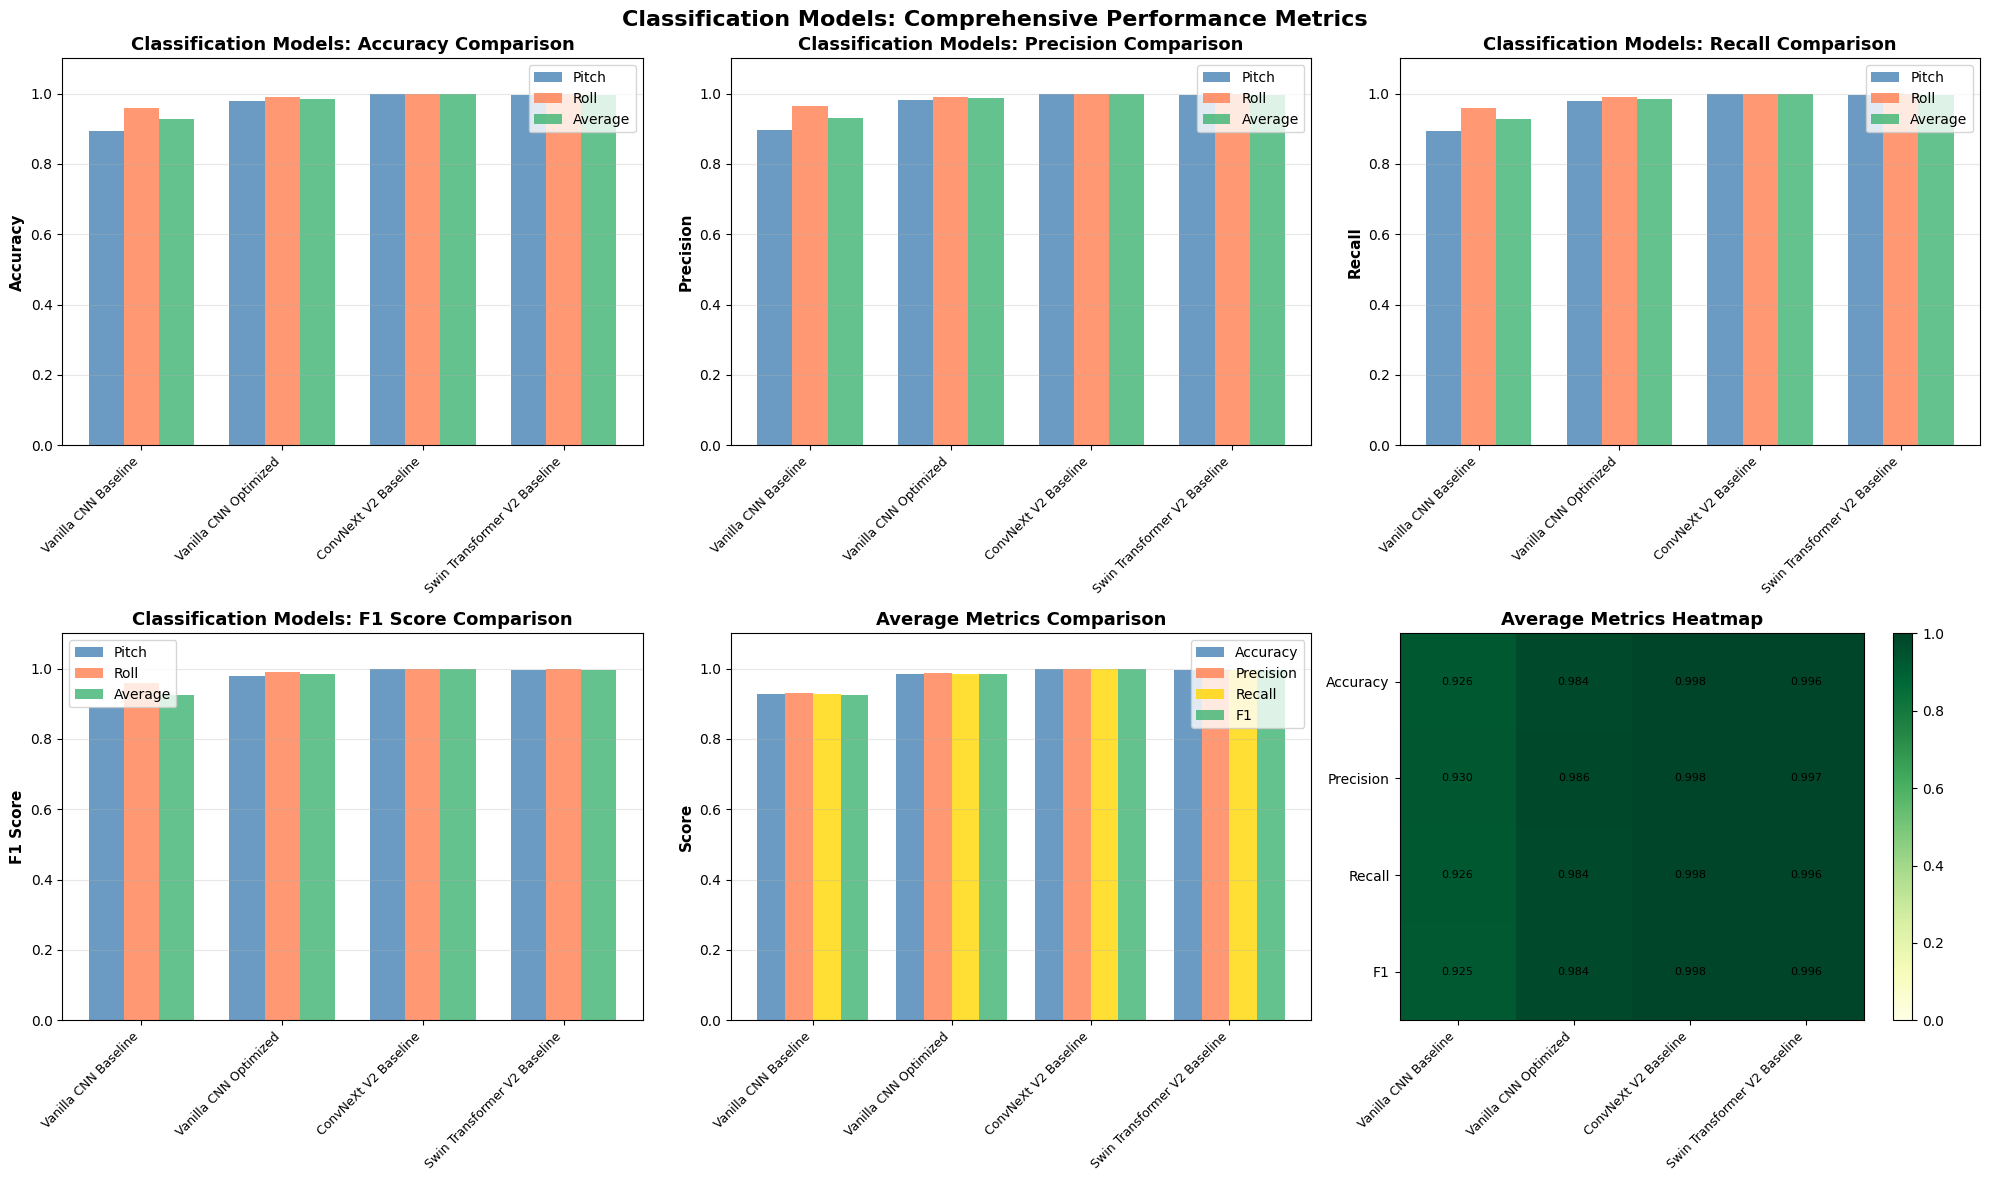

Classification comparison plot saved


In [11]:
# Plot classification models comparison
if cls_models:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    model_names = [v['name'] for _, v in cls_models]
    pitch_accs = [v['metrics']['pitch']['accuracy'] for _, v in cls_models]
    roll_accs = [v['metrics']['roll']['accuracy'] for _, v in cls_models]
    avg_accs = [v['metrics']['average']['accuracy'] for _, v in cls_models]
    
    pitch_precs = [v['metrics']['pitch']['precision'] for _, v in cls_models]
    roll_precs = [v['metrics']['roll']['precision'] for _, v in cls_models]
    avg_precs = [v['metrics']['average']['precision'] for _, v in cls_models]
    
    pitch_recs = [v['metrics']['pitch']['recall'] for _, v in cls_models]
    roll_recs = [v['metrics']['roll']['recall'] for _, v in cls_models]
    avg_recs = [v['metrics']['average']['recall'] for _, v in cls_models]
    
    pitch_f1s = [v['metrics']['pitch']['f1'] for _, v in cls_models]
    roll_f1s = [v['metrics']['roll']['f1'] for _, v in cls_models]
    avg_f1s = [v['metrics']['average']['f1'] for _, v in cls_models]
    
    x = np.arange(len(model_names))
    width = 0.25
    
    # 1. Accuracy comparison
    axes[0, 0].bar(x - width, pitch_accs, width, label='Pitch', alpha=0.8, color='steelblue')
    axes[0, 0].bar(x, roll_accs, width, label='Roll', alpha=0.8, color='coral')
    axes[0, 0].bar(x + width, avg_accs, width, label='Average', alpha=0.8, color='mediumseagreen')
    axes[0, 0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
    axes[0, 0].set_title('Classification Models: Accuracy Comparison', fontweight='bold', fontsize=13)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1.1])
    
    # 2. Precision comparison
    axes[0, 1].bar(x - width, pitch_precs, width, label='Pitch', alpha=0.8, color='steelblue')
    axes[0, 1].bar(x, roll_precs, width, label='Roll', alpha=0.8, color='coral')
    axes[0, 1].bar(x + width, avg_precs, width, label='Average', alpha=0.8, color='mediumseagreen')
    axes[0, 1].set_ylabel('Precision', fontweight='bold', fontsize=11)
    axes[0, 1].set_title('Classification Models: Precision Comparison', fontweight='bold', fontsize=13)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([0, 1.1])
    
    # 3. Recall comparison
    axes[0, 2].bar(x - width, pitch_recs, width, label='Pitch', alpha=0.8, color='steelblue')
    axes[0, 2].bar(x, roll_recs, width, label='Roll', alpha=0.8, color='coral')
    axes[0, 2].bar(x + width, avg_recs, width, label='Average', alpha=0.8, color='mediumseagreen')
    axes[0, 2].set_ylabel('Recall', fontweight='bold', fontsize=11)
    axes[0, 2].set_title('Classification Models: Recall Comparison', fontweight='bold', fontsize=13)
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[0, 2].legend()
    axes[0, 2].grid(axis='y', alpha=0.3)
    axes[0, 2].set_ylim([0, 1.1])
    
    # 4. F1 Score comparison
    axes[1, 0].bar(x - width, pitch_f1s, width, label='Pitch', alpha=0.8, color='steelblue')
    axes[1, 0].bar(x, roll_f1s, width, label='Roll', alpha=0.8, color='coral')
    axes[1, 0].bar(x + width, avg_f1s, width, label='Average', alpha=0.8, color='mediumseagreen')
    axes[1, 0].set_ylabel('F1 Score', fontweight='bold', fontsize=11)
    axes[1, 0].set_title('Classification Models: F1 Score Comparison', fontweight='bold', fontsize=13)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_ylim([0, 1.1])
    
    # 5. Average metrics comparison (bar chart)
    width_avg = 0.2
    axes[1, 1].bar(x - 1.5*width_avg, avg_accs, width_avg, label='Accuracy', alpha=0.8, color='steelblue')
    axes[1, 1].bar(x - 0.5*width_avg, avg_precs, width_avg, label='Precision', alpha=0.8, color='coral')
    axes[1, 1].bar(x + 0.5*width_avg, avg_recs, width_avg, label='Recall', alpha=0.8, color='gold')
    axes[1, 1].bar(x + 1.5*width_avg, avg_f1s, width_avg, label='F1', alpha=0.8, color='mediumseagreen')
    axes[1, 1].set_ylabel('Score', fontweight='bold', fontsize=11)
    axes[1, 1].set_title('Average Metrics Comparison', fontweight='bold', fontsize=13)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].set_ylim([0, 1.1])
    
    # 6. Summary heatmap
    metrics_matrix = np.array([avg_accs, avg_precs, avg_recs, avg_f1s])
    im = axes[1, 2].imshow(metrics_matrix, aspect='auto', cmap='YlGn', vmin=0, vmax=1)
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[1, 2].set_yticks([0, 1, 2, 3])
    axes[1, 2].set_yticklabels(['Accuracy', 'Precision', 'Recall', 'F1'], fontsize=10)
    axes[1, 2].set_title('Average Metrics Heatmap', fontweight='bold', fontsize=13)
    
    # Add values to heatmap
    for i in range(len(['Accuracy', 'Precision', 'Recall', 'F1'])):
        for j in range(len(model_names)):
            text = axes[1, 2].text(j, i, f'{metrics_matrix[i, j]:.3f}',
                                   ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=axes[1, 2])
    
    plt.suptitle('Classification Models: Comprehensive Performance Metrics', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / 'classification_models_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Classification comparison plot saved")

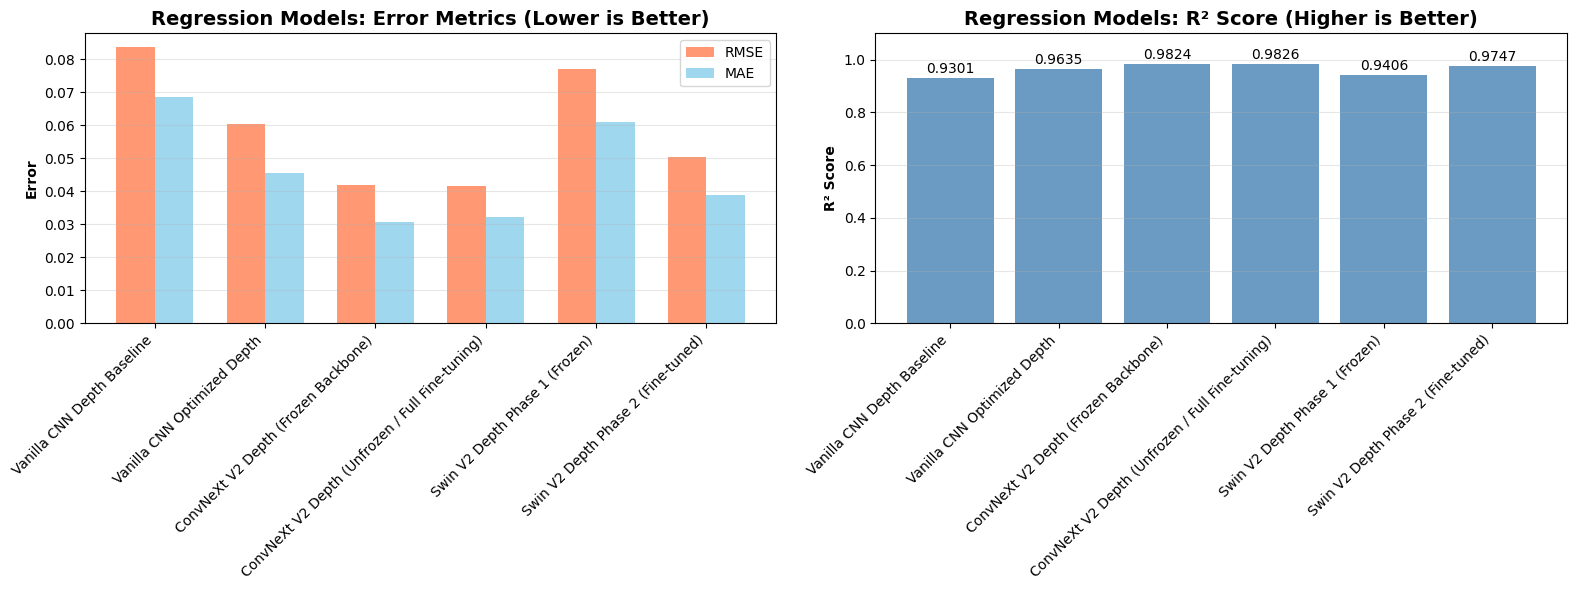

Regression comparison plot saved


In [12]:
# Plot regression models comparison
if reg_models:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    model_names = [v['name'] for _, v in reg_models]
    rmses = [v['metrics']['rmse'] for _, v in reg_models]
    maes = [v['metrics']['mae'] for _, v in reg_models]
    r2s = [v['metrics']['r2'] for _, v in reg_models]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    # RMSE and MAE comparison
    axes[0].bar(x - width/2, rmses, width, label='RMSE', alpha=0.8, color='coral')
    axes[0].bar(x + width/2, maes, width, label='MAE', alpha=0.8, color='skyblue')
    axes[0].set_ylabel('Error', fontweight='bold')
    axes[0].set_title('Regression Models: Error Metrics (Lower is Better)', fontweight='bold', fontsize=14)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # R² comparison
    bars = axes[1].bar(x, r2s, alpha=0.8, color='steelblue')
    axes[1].set_ylabel('R² Score', fontweight='bold')
    axes[1].set_title('Regression Models: R² Score (Higher is Better)', fontweight='bold', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim([0, 1.1])
    
    # Add value labels
    for i, r2 in enumerate(r2s):
        axes[1].text(i, r2 + 0.02, f'{r2:.4f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(project_root / 'reports' / 'regression_models_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Regression comparison plot saved")

## 9. Computational Cost Analysis

Measure computational efficiency metrics for each model:
- **Parameters**: Total number of trainable parameters
- **Model Size**: File size on disk (MB)
- **Inference Time**: Average time per image (ms)
- **FLOPs**: Floating-point operations per forward pass (GFLOPs)
- **Throughput**: Images processed per second

In [13]:
# Find best models
print("\n" + "="*80)
print("BEST MODELS")
print("="*80)

if cls_models:
    best_cls = max(cls_models, key=lambda x: x[1]['metrics']['average']['accuracy'])
    print("\n Best Classification Model:")
    print(f"   Name: {best_cls[1]['name']}")
    print(f"\n   Pitch Metrics:")
    print(f"      Accuracy:  {best_cls[1]['metrics']['pitch']['accuracy']:.4f}")
    print(f"      Precision: {best_cls[1]['metrics']['pitch']['precision']:.4f}")
    print(f"      Recall:    {best_cls[1]['metrics']['pitch']['recall']:.4f}")
    print(f"      F1 Score:  {best_cls[1]['metrics']['pitch']['f1']:.4f}")
    print(f"\n   Roll Metrics:")
    print(f"      Accuracy:  {best_cls[1]['metrics']['roll']['accuracy']:.4f}")
    print(f"      Precision: {best_cls[1]['metrics']['roll']['precision']:.4f}")
    print(f"      Recall:    {best_cls[1]['metrics']['roll']['recall']:.4f}")
    print(f"      F1 Score:  {best_cls[1]['metrics']['roll']['f1']:.4f}")
    print(f"\n   Average Metrics:")
    print(f"      Accuracy:  {best_cls[1]['metrics']['average']['accuracy']:.4f}")
    print(f"      Precision: {best_cls[1]['metrics']['average']['precision']:.4f}")
    print(f"      Recall:    {best_cls[1]['metrics']['average']['recall']:.4f}")
    print(f"      F1 Score:  {best_cls[1]['metrics']['average']['f1']:.4f}")

if reg_models:
    best_reg = min(reg_models, key=lambda x: x[1]['metrics']['rmse'])
    print("\n Best Regression Model:")
    print(f"   Name: {best_reg[1]['name']}")
    print(f"   RMSE: {best_reg[1]['metrics']['rmse']:.6f}")
    print(f"   MAE: {best_reg[1]['metrics']['mae']:.6f}")
    print(f"   R²: {best_reg[1]['metrics']['r2']:.6f}")
    print(f"   Median AE: {best_reg[1]['metrics']['median_ae']:.6f}")

print("\n" + "="*80)


BEST MODELS

 Best Classification Model:
   Name: ConvNeXt V2 Baseline

   Pitch Metrics:
      Accuracy:  0.9975
      Precision: 0.9977
      Recall:    0.9975
      F1 Score:  0.9976

   Roll Metrics:
      Accuracy:  0.9975
      Precision: 0.9976
      Recall:    0.9975
      F1 Score:  0.9975

   Average Metrics:
      Accuracy:  0.9975
      Precision: 0.9976
      Recall:    0.9975
      F1 Score:  0.9975

 Best Regression Model:
   Name: ConvNeXt V2 Depth (Unfrozen / Full Fine-tuning)
   RMSE: 0.041731
   MAE: 0.032083
   R²: 0.982617
   Median AE: 0.025935



## 10. Best Model Selection

In [14]:
import time

def compute_computational_cost(model, model_file, input_size=(3, 224, 224), device='cpu', num_warmup=10, num_iter=100):
    """
    Compute comprehensive computational cost metrics for a model
    
    Args:
        model: PyTorch model
        model_file: Path to model checkpoint file
        input_size: Input tensor size (C, H, W)
        device: Device to run on
        num_warmup: Number of warmup iterations
        num_iter: Number of iterations for timing
    
    Returns:
        Dictionary with computational metrics
    """
    model.eval()
    model.to(device)
    
    # 1. Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # 2. Get model file size
    model_size_mb = model_file.stat().st_size / (1024 * 1024)
    
    # 3. Measure inference time
    dummy_input = torch.randn(1, *input_size).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(dummy_input)
    
    # Synchronize device (important for MPS/CUDA)
    if device.type == 'mps':
        torch.mps.synchronize()
    elif device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Measure time
    times = []
    with torch.no_grad():
        for _ in range(num_iter):
            start_time = time.perf_counter()
            _ = model(dummy_input)
            
            # Synchronize
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.perf_counter()
            times.append((end_time - start_time) * 1000)  # Convert to ms
    
    avg_time_ms = np.mean(times)
    std_time_ms = np.std(times)
    throughput = 1000.0 / avg_time_ms  # images per second
    
    # 4. Estimate FLOPs (simple approximation)
    # Note: Accurate FLOP counting requires specialized libraries (thop, fvcore)
    # This is a rough estimate based on model parameters
    # Real FLOPs calculation would need to trace the model
    flops_estimate = None
    try:
        # Try to use thop if available
        from thop import profile, clever_format
        dummy_input_cpu = torch.randn(1, *input_size)
        model_cpu = model.cpu()
        macs, params = profile(model_cpu, inputs=(dummy_input_cpu,), verbose=False)
        flops_estimate = macs * 2  # MACs to FLOPs (roughly 2x)
        model.to(device)  # Move back to device
    except ImportError:
        # Fallback: rough estimate based on parameters
        # This is very approximate
        flops_estimate = total_params * 2  # Rough approximation
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': model_size_mb,
        'avg_inference_time_ms': avg_time_ms,
        'std_inference_time_ms': std_time_ms,
        'throughput_fps': throughput,
        'flops_estimate': flops_estimate
    }

print("Computational cost function defined")

Computational cost function defined


In [15]:
# Compute computational cost for all models
computational_costs = {}

print("Computing computational costs for all models...")
print("=" * 80)
print("This may take a few minutes as we measure inference time over 100 iterations\n")

for model_file, model_spec in MODEL_REGISTRY.items():
    model_path = models_dir / model_file
    
    if not model_path.exists():
        continue
    
    print(f"  Analyzing: {model_spec['name']}")
    
    try:
        # Load model
        model = load_model(model_path, model_spec, device)
        
        # Determine input size
        input_size = (3, 256, 256) if model_spec['resize'] == 256 else (3, 224, 224)
        
        # Compute costs
        costs = compute_computational_cost(
            model=model,
            model_file=model_path,
            input_size=input_size,
            device=device,
            num_warmup=10,
            num_iter=100
        )
        
        computational_costs[model_file] = {
            'name': model_spec['name'],
            'type': model_spec['type'],
            **costs
        }
        
        print(f"   Parameters: {costs['total_params']:,}")
        print(f"   Model Size: {costs['model_size_mb']:.2f} MB")
        print(f"   Avg Inference Time: {costs['avg_inference_time_ms']:.2f} ± {costs['std_inference_time_ms']:.2f} ms")
        print(f"   Throughput: {costs['throughput_fps']:.1f} FPS")
        if costs['flops_estimate']:
            print(f"   FLOPs (estimate): {costs['flops_estimate']/1e9:.2f} GFLOPs")
        print()
        
        # Clean up
        del model
        if device.type == 'mps':
            torch.mps.empty_cache()
        
    except Exception as e:
        print(f"    ERROR: {str(e)}\n")
        continue

print("=" * 80)
print(f"Computational cost analysis completed for {len(computational_costs)} models")

Computing computational costs for all models...
This may take a few minutes as we measure inference time over 100 iterations

  Analyzing: Vanilla CNN Baseline
   Parameters: 1,708,313
   Model Size: 6.54 MB
   Avg Inference Time: 1.54 ± 0.04 ms
   Throughput: 651.0 FPS
   FLOPs (estimate): 0.00 GFLOPs

  Analyzing: Vanilla CNN Optimized
   Parameters: 308,953
   Model Size: 1.20 MB
   Avg Inference Time: 1.41 ± 0.05 ms
   Throughput: 709.6 FPS
   FLOPs (estimate): 0.00 GFLOPs

  Analyzing: ConvNeXt V2 Baseline
   Parameters: 28,266,649
   Model Size: 107.91 MB
   Avg Inference Time: 10.22 ± 0.19 ms
   Throughput: 97.8 FPS
   FLOPs (estimate): 0.06 GFLOPs

  Analyzing: Swin Transformer V2 Baseline
   Parameters: 27,600,451
   Model Size: 105.38 MB
   Avg Inference Time: 22.35 ± 1.83 ms
   Throughput: 44.7 FPS
   FLOPs (estimate): 0.06 GFLOPs

  Analyzing: Vanilla CNN Depth Baseline
   Parameters: 1,702,145
   Model Size: 19.54 MB
   Avg Inference Time: 1.61 ± 0.05 ms
   Throughput: 620

In [16]:
computational_costs

{'1_vanilla_cnn_baseline_best.pth': {'name': 'Vanilla CNN Baseline',
  'type': 'classification',
  'total_params': 1708313,
  'trainable_params': 1708313,
  'model_size_mb': 6.538320541381836,
  'avg_inference_time_ms': np.float64(1.5362128673586994),
  'std_inference_time_ms': np.float64(0.04338443828247123),
  'throughput_fps': np.float64(650.9514542208974),
  'flops_estimate': 3416626},
 '2_vanilla_cnn_optimized_best.pth': {'name': 'Vanilla CNN Optimized',
  'type': 'classification',
  'total_params': 308953,
  'trainable_params': 308953,
  'model_size_mb': 1.195652961730957,
  'avg_inference_time_ms': np.float64(1.409204169176519),
  'std_inference_time_ms': np.float64(0.05304964438779249),
  'throughput_fps': np.float64(709.6203813989274),
  'flops_estimate': 617906},
 '3_convnextv2_pose.pth': {'name': 'ConvNeXt V2 Baseline',
  'type': 'classification',
  'total_params': 28266649,
  'trainable_params': 28266649,
  'model_size_mb': 107.9080114364624,
  'avg_inference_time_ms': np.f

In [17]:
# Create comprehensive computational cost summary table
print("\n" + "="*120)
print("COMPUTATIONAL COST SUMMARY")
print("="*120)

cost_data = []
for model_file, costs in computational_costs.items():
    cost_data.append({
        'Model': costs['name'],
        'Type': costs['type'].capitalize(),
        'Parameters (M)': f"{costs['total_params']/1e6:.2f}",
        'Size (MB)': f"{costs['model_size_mb']:.2f}",
        'Inference (ms)': f"{costs['avg_inference_time_ms']:.2f} ± {costs['std_inference_time_ms']:.2f}",
        'Throughput (FPS)': f"{costs['throughput_fps']:.1f}",
        'FLOPs (G)': f"{costs['flops_estimate']/1e9:.2f}" if costs['flops_estimate'] else 'N/A'
    })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.sort_values('Type')
print(cost_df.to_string(index=False))
print("="*120)

# Save to CSV
cost_df.to_csv(project_root / 'reports' / 'computational_costs.csv', index=False)
print("\n Computational cost table saved to: reports/computational_costs.csv")


COMPUTATIONAL COST SUMMARY
                                          Model           Type Parameters (M) Size (MB) Inference (ms) Throughput (FPS) FLOPs (G)
                           Vanilla CNN Baseline Classification           1.71      6.54    1.54 ± 0.04            651.0      0.00
                          Vanilla CNN Optimized Classification           0.31      1.20    1.41 ± 0.05            709.6      0.00
                           ConvNeXt V2 Baseline Classification          28.27    107.91   10.22 ± 0.19             97.8      0.06
                   Swin Transformer V2 Baseline Classification          27.60    105.38   22.35 ± 1.83             44.7      0.06
                     Vanilla CNN Depth Baseline     Regression           1.70     19.54    1.61 ± 0.05            620.3      0.00
                    Vanilla CNN Optimized Depth     Regression           0.30      3.47    1.40 ± 0.04            713.7      0.00
            ConvNeXt V2 Depth (Frozen Backbone)     Regression

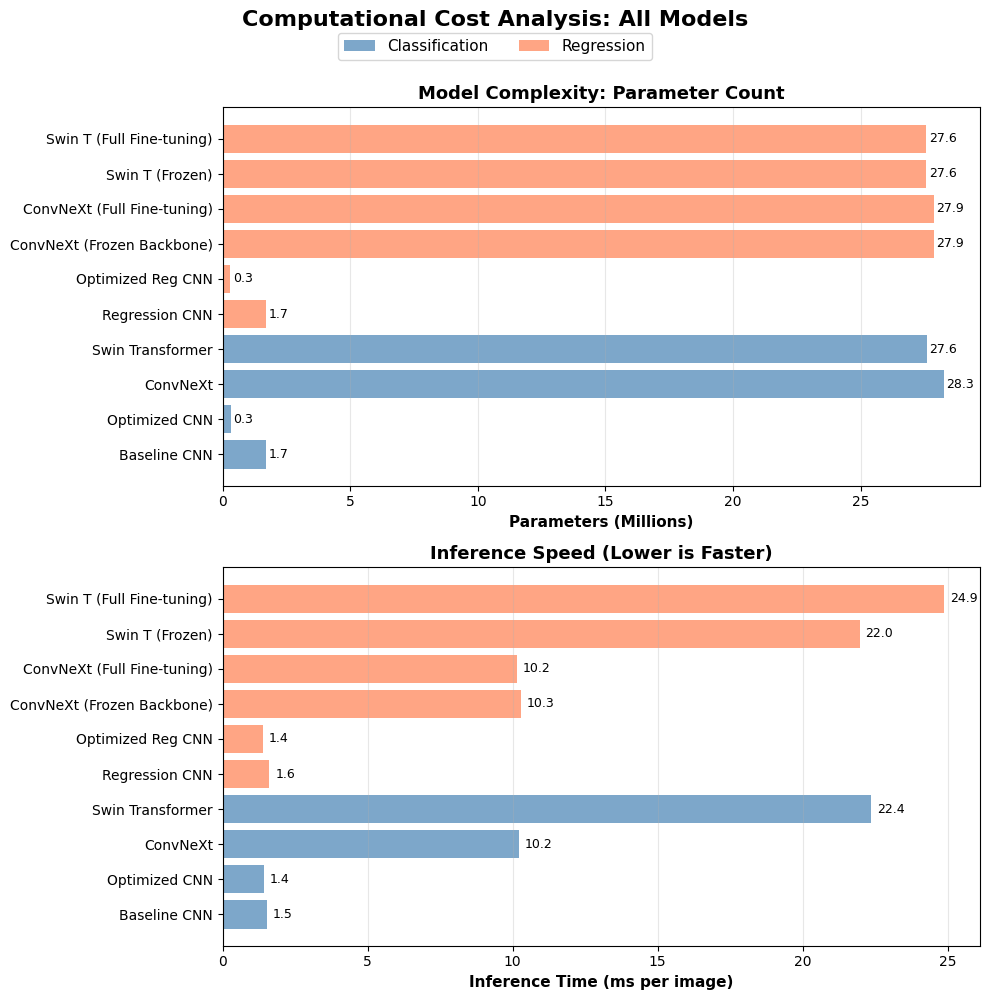

Computational cost visualization saved


In [18]:
# Visualize computational costs
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(left=0.28, right=0.98, top=0.94, bottom=0.06)

model_names = [costs['name'] for costs in computational_costs.values()]
model_types = [costs['type'] for costs in computational_costs.values()]

model_names = ['Baseline CNN',
 'Optimized CNN',
 'ConvNeXt',
 'Swin Transformer',
 'Regression CNN',
 'Optimized Reg CNN',
 'ConvNeXt (Frozen Backbone)',
 'ConvNeXt (Full Fine-tuning)',
 'Swin T (Frozen)',
 'Swin T (Full Fine-tuning)']

# Color by type
colors = ['steelblue' if t == 'classification' else 'coral' for t in model_types]

# 1. Parameters comparison
params_millions = [costs['total_params']/1e6 for costs in computational_costs.values()]
bars = axes[0].barh(model_names, params_millions, color=colors, alpha=0.7)
axes[0].set_xlabel('Parameters (Millions)', fontweight='bold', fontsize=11)
axes[0].set_title('Model Complexity: Parameter Count', fontweight='bold', fontsize=13)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, params_millions)):
    axes[0].text(val + 0.1, bar.get_y() + bar.get_height()/2, 
                    f'{val:.1f}', va='center', fontsize=9)

# 2. Inference time comparison
inference_times = [costs['avg_inference_time_ms'] for costs in computational_costs.values()]
bars = axes[1].barh(model_names, inference_times, color=colors, alpha=0.7)
axes[1].set_xlabel('Inference Time (ms per image)', fontweight='bold', fontsize=11)
axes[1].set_title('Inference Speed (Lower is Faster)', fontweight='bold', fontsize=13)
axes[1].grid(axis='x', alpha=0.3)
# Add value labels
for i, (bar, val) in enumerate(zip(bars, inference_times)):
    axes[1].text(val + 0.2, bar.get_y() + bar.get_height()/2, 
                    f'{val:.1f}', va='center', fontsize=9)



# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Classification'),
    Patch(facecolor='coral', alpha=0.7, label='Regression')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 0.98), fontsize=11, frameon=True)

plt.suptitle('Computational Cost Analysis: All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(project_root / 'reports' / 'computational_costs_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Computational cost visualization saved")

In [19]:
model_names = ['Baseline CNN',
 'Optimized CNN',
 'ConvNeXt',
 'Swin Transformer',
 'Regression CNN',
 'Optimized Reg CNN',
 'ConvNeXt (Frozen Backbone)',
 'ConvNeXt (Full Fine-tuning)',
 'Swin T (Frozen)',
 'Swin T (Full Fine-tuning)']

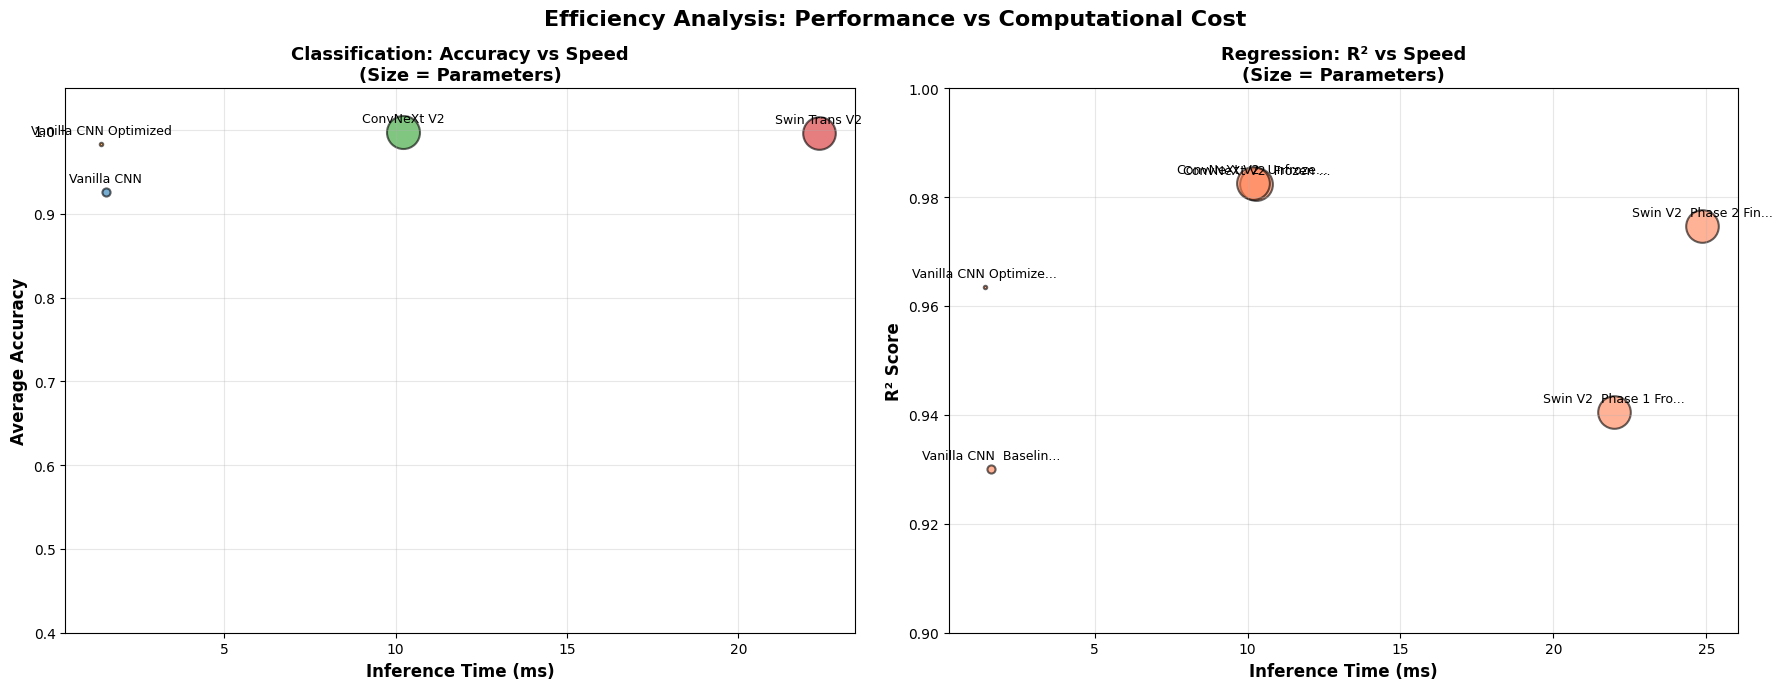


 Efficiency analysis saved

 Key Insights:
   - Larger bubbles = More parameters
   - Top-left corner = Best efficiency (high performance, low latency)
   - Bottom-right corner = Worst efficiency (low performance, high latency)


In [20]:
# Efficiency Analysis: Performance vs Computational Cost
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Separate classification and regression models
cls_costs = [(k, v) for k, v in computational_costs.items() if v['type'] == 'classification']
reg_costs = [(k, v) for k, v in computational_costs.items() if v['type'] == 'regression']

# 1. Classification: Accuracy vs Inference Time
if cls_costs:
    for model_file, cost_data in cls_costs:
        if model_file in results:
            accuracy = results[model_file]['metrics']['average']['accuracy']
            inf_time = cost_data['avg_inference_time_ms']
            params_m = cost_data['total_params'] / 1e6
            
            # Plot point
            axes[0].scatter(inf_time, accuracy, s=params_m*20, alpha=0.6, edgecolors='black', linewidth=1.5)
            
            # Add label
            model_name = cost_data['name'].replace('Baseline', '').replace('Transformer', 'Trans').strip()
            axes[0].annotate(model_name, (inf_time, accuracy), 
                           fontsize=9, ha='center', va='bottom', 
                           xytext=(0, 5), textcoords='offset points')
    
    axes[0].set_xlabel('Inference Time (ms)', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Average Accuracy', fontweight='bold', fontsize=12)
    axes[0].set_title('Classification: Accuracy vs Speed\n(Size = Parameters)', 
                     fontweight='bold', fontsize=13)
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim([0.4, 1.05])

# 2. Regression: R² vs Inference Time
if reg_costs:
    for model_file, cost_data in reg_costs:
        if model_file in results:
            r2 = results[model_file]['metrics']['r2']
            inf_time = cost_data['avg_inference_time_ms']
            params_m = cost_data['total_params'] / 1e6
            
            # Plot point
            axes[1].scatter(inf_time, r2, s=params_m*20, alpha=0.6, edgecolors='black', linewidth=1.5, color='coral')
            
            # Add label
            model_name = cost_data['name'].replace('Depth', '').replace('Backbone', 'BB').replace('(', '').replace(')', '').strip()
            if len(model_name) > 20:
                model_name = model_name[:20] + '...'
            axes[1].annotate(model_name, (inf_time, r2), 
                           fontsize=9, ha='center', va='bottom',
                           xytext=(0, 5), textcoords='offset points')
    
    axes[1].set_xlabel('Inference Time (ms)', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('R² Score', fontweight='bold', fontsize=12)
    axes[1].set_title('Regression: R² vs Speed\n(Size = Parameters)', 
                     fontweight='bold', fontsize=13)
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0.90, 1.0])

plt.suptitle('Efficiency Analysis: Performance vs Computational Cost', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'reports' / 'efficiency_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n Efficiency analysis saved")
print("\n Key Insights:")
print("   - Larger bubbles = More parameters")
print("   - Top-left corner = Best efficiency (high performance, low latency)")
print("   - Bottom-right corner = Worst efficiency (low performance, high latency)")

In [21]:
# Summary: Best models by different criteria
print("\n" + "="*100)
print("BEST MODELS BY CRITERIA")
print("="*100)

# Classification models
cls_models_full = [(k, results[k], computational_costs[k]) 
                   for k in results.keys() 
                   if results[k]['type'] == 'classification' and k in computational_costs]

if cls_models_full:
    print("\n CLASSIFICATION MODELS:")
    
    # Best accuracy
    best_acc = max(cls_models_full, key=lambda x: x[1]['metrics']['average']['accuracy'])
    print(f"\n   Best Accuracy: {best_acc[1]['name']}")
    print(f"      Accuracy: {best_acc[1]['metrics']['average']['accuracy']:.4f}")
    print(f"      Inference: {best_acc[2]['avg_inference_time_ms']:.2f} ms")
    print(f"      Parameters: {best_acc[2]['total_params']/1e6:.2f}M")
    
    # Fastest
    fastest = min(cls_models_full, key=lambda x: x[2]['avg_inference_time_ms'])
    print(f"\n   Fastest Inference: {fastest[1]['name']}")
    print(f"      Inference: {fastest[2]['avg_inference_time_ms']:.2f} ms")
    print(f"      Accuracy: {fastest[1]['metrics']['average']['accuracy']:.4f}")
    print(f"      Throughput: {fastest[2]['throughput_fps']:.1f} FPS")
    
    # Most efficient (accuracy per ms)
    efficiency_scores = [(k, r, c, r['metrics']['average']['accuracy'] / c['avg_inference_time_ms']) 
                        for k, r, c in cls_models_full]
    most_efficient = max(efficiency_scores, key=lambda x: x[3])
    print(f"\n   Most Efficient (Accuracy/ms): {most_efficient[1]['name']}")
    print(f"      Efficiency Score: {most_efficient[3]:.4f} acc/ms")
    print(f"      Accuracy: {most_efficient[1]['metrics']['average']['accuracy']:.4f}")
    print(f"      Inference: {most_efficient[2]['avg_inference_time_ms']:.2f} ms")
    
    # Smallest
    smallest = min(cls_models_full, key=lambda x: x[2]['total_params'])
    print(f"\n   Smallest Model: {smallest[1]['name']}")
    print(f"      Parameters: {smallest[2]['total_params']/1e6:.2f}M")
    print(f"      Size: {smallest[2]['model_size_mb']:.2f} MB")
    print(f"      Accuracy: {smallest[1]['metrics']['average']['accuracy']:.4f}")

# Regression models
reg_models_full = [(k, results[k], computational_costs[k]) 
                   for k in results.keys() 
                   if results[k]['type'] == 'regression' and k in computational_costs]

if reg_models_full:
    print("\n\n🏆 REGRESSION MODELS:")
    
    # Best R²
    best_r2 = max(reg_models_full, key=lambda x: x[1]['metrics']['r2'])
    print(f"\n   Best R² Score: {best_r2[1]['name']}")
    print(f"      R²: {best_r2[1]['metrics']['r2']:.6f}")
    print(f"      RMSE: {best_r2[1]['metrics']['rmse']:.6f}")
    print(f"      Inference: {best_r2[2]['avg_inference_time_ms']:.2f} ms")
    
    # Lowest error
    lowest_rmse = min(reg_models_full, key=lambda x: x[1]['metrics']['rmse'])
    print(f"\n   Lowest RMSE: {lowest_rmse[1]['name']}")
    print(f"      RMSE: {lowest_rmse[1]['metrics']['rmse']:.6f}")
    print(f"      MAE: {lowest_rmse[1]['metrics']['mae']:.6f}")
    print(f"      R²: {lowest_rmse[1]['metrics']['r2']:.6f}")
    
    # Fastest
    fastest_reg = min(reg_models_full, key=lambda x: x[2]['avg_inference_time_ms'])
    print(f"\n   Fastest Inference: {fastest_reg[1]['name']}")
    print(f"      Inference: {fastest_reg[2]['avg_inference_time_ms']:.2f} ms")
    print(f"      RMSE: {fastest_reg[1]['metrics']['rmse']:.6f}")
    print(f"      Throughput: {fastest_reg[2]['throughput_fps']:.1f} FPS")
    
    # Most efficient (R² per ms)
    efficiency_scores_reg = [(k, r, c, r['metrics']['r2'] / c['avg_inference_time_ms']) 
                            for k, r, c in reg_models_full]
    most_efficient_reg = max(efficiency_scores_reg, key=lambda x: x[3])
    print(f"\n   Most Efficient (R²/ms): {most_efficient_reg[1]['name']}")
    print(f"      Efficiency Score: {most_efficient_reg[3]:.4f} R²/ms")
    print(f"      R²: {most_efficient_reg[1]['metrics']['r2']:.6f}")
    print(f"      Inference: {most_efficient_reg[2]['avg_inference_time_ms']:.2f} ms")

print("\n" + "="*100)
print("\n Computational cost analysis complete!")


BEST MODELS BY CRITERIA

 CLASSIFICATION MODELS:

   Best Accuracy: ConvNeXt V2 Baseline
      Accuracy: 0.9975
      Inference: 10.22 ms
      Parameters: 28.27M

   Fastest Inference: Vanilla CNN Optimized
      Inference: 1.41 ms
      Accuracy: 0.9838
      Throughput: 709.6 FPS

   Most Efficient (Accuracy/ms): Vanilla CNN Optimized
      Efficiency Score: 0.6981 acc/ms
      Accuracy: 0.9838
      Inference: 1.41 ms

   Smallest Model: Vanilla CNN Optimized
      Parameters: 0.31M
      Size: 1.20 MB
      Accuracy: 0.9838


🏆 REGRESSION MODELS:

   Best R² Score: ConvNeXt V2 Depth (Unfrozen / Full Fine-tuning)
      R²: 0.982617
      RMSE: 0.041731
      Inference: 10.16 ms

   Lowest RMSE: ConvNeXt V2 Depth (Unfrozen / Full Fine-tuning)
      RMSE: 0.041731
      MAE: 0.032083
      R²: 0.982617

   Fastest Inference: Vanilla CNN Optimized Depth
      Inference: 1.40 ms
      RMSE: 0.060475
      Throughput: 713.7 FPS

   Most Efficient (R²/ms): Vanilla CNN Optimized Depth
  